Simulating an Airplane in 2d
state x is [x_pos, z_pos, velocity, and upsilon (flight path angle, angle between earth frame and velocity frame )] ^T
input is [Thrust T, alpha (angel of attack, angel between body frame and velocity frame)]^T

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import yaml


In [14]:
def find_steady_straight_flight(earth_to_wind_angle, V_magnitude):

    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass']   

    def equations(vars):
        u, w, theta, alpha, elevator = vars
        
        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
                params['long_coef']['C_L_elevator'] * elevator
            
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_elevator'] * elevator
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
                params['long_coef']['C_M_moment_elevator'] * elevator
        w_dot = g*np.cos(theta) - D*np.sin(alpha)/mass - L*np.cos(alpha)/mass
        alpha_zero = alpha - np.arctan2(w,u)
        V_magnitude_zero = V_magnitude - np.sqrt(u**2 + w**2)
        earth_to_wind_angle_zero = earth_to_wind_angle - (theta-alpha)

        return [C_M_moment, w_dot, alpha_zero, V_magnitude_zero, earth_to_wind_angle_zero]
    
    u, w, theta, alpha, elevator = fsolve(equations, (1, 1, earth_to_wind_angle, 0, 0))

    # now solve for T
    V_magnitude = np.sqrt(u**2 + w**2)
    C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_elevator'] * elevator
            
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_elevator'] * elevator

    L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

    T = g*np.sin(theta)*mass + D*np.cos(alpha) -L*np.sin(alpha)
            
    return(u, w, theta, alpha, elevator, T)

In [15]:
def find_steady_turn(psi_dot):
    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass'] 
    Ixx = params['physical']['Ixx']
    Iyy = params['physical']['Iyy']
    Izz = params['physical']['Izz']
    Ixz = params['physical']['Ixz']
    
    alpha = 0
    beta = 0
    theta = 0
    p = 0
    v = 0
    w = 0

    def equations(vars):
        phi, u, r, q, elevator, aileron, rudder = vars
        V_magnitude = u

        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_L_elevator'] * elevator
        
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_D_elevator'] * elevator
        
        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
            params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_M_moment_elevator'] * elevator
        
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
        M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['c_wing_chord'] * C_M_moment
        

        C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
            params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_y_aileron'] * aileron + params['lat_coef']['C_y_rudder'] * rudder
        
        C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
            params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_L_moment_aileron'] * aileron + params['lat_coef']['C_L_moment_rudder'] * rudder
        
        C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
            params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_N_moment_aileron'] * aileron + params['lat_coef']['C_N_moment_rudder'] * rudder

        F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
        L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
                    * params['physical']['b_wing_span'] * C_L_moment
        N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['b_wing_span'] * C_N_moment
        
        # 7 equations
        phi_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot_zero = psi_dot - (q*np.sin(phi)+r*np.cos(phi))
        v_dot = g*np.cos(theta)*np.sin(phi) - D*np.sin(beta)/mass + F_y/mass -r*u+p*w
        w_dot = g*np.cos(theta)*np.cos(phi) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q*u
        p_dot = ( -q*r*(Izz-Iyy) + N_moment*Ixz/Izz - p*q*Ixz*(Iyy-Ixx)/Izz - q*r*Ixz*Ixz/Izz +p*q*Ixz + L_moment)\
                                / (Ixx - Ixz*Ixz/Izz)
        
        q_dot = ( M_moment + p*r*(Izz-Ixx)-(p**2 - r**2)*Ixz ) / Iyy

        r_dot = ( -p*q*(Iyy-Ixx) - q*r*Ixz + L_moment*Ixz/Ixx - q*r*Ixz*(Izz-Iyy)/Ixx + p*q*Ixz*Ixz/Ixx + N_moment)\
                                / (Izz - Ixz*Ixz/Ixx)
        
        
        return[phi_dot, psi_dot_zero, v_dot, w_dot, p_dot, q_dot, r_dot]

    
    phi, u, r, q, elevator, aileron, rudder = fsolve(equations, (np.pi/4, 100, 0, 0, 0, 0, 0), maxfev=70000)

    # now solve for T    
    V_magnitude = u
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
        params['long_coef']['C_D_elevator'] * elevator

    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D     

    T = D

    return phi, u, r, q, T, elevator, aileron, rudder

    

In [16]:
def find_steady_turn_radius(radius):
    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass'] 
    Ixx = params['physical']['Ixx']
    Iyy = params['physical']['Iyy']
    Izz = params['physical']['Izz']
    Ixz = params['physical']['Ixz']
    
    alpha = 0
    beta = 0
    theta = 0
    p = 0
    v = 0
    w = 0

    def equations(vars):
        phi, psi_dot, u, r, q, elevator, aileron, rudder = vars
        V_magnitude = u

        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_L_elevator'] * elevator
        
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_D_elevator'] * elevator
        
        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
            params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_M_moment_elevator'] * elevator
        
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
        M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['c_wing_chord'] * C_M_moment
        

        C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
            params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_y_aileron'] * aileron + params['lat_coef']['C_y_rudder'] * rudder
        
        C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
            params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_L_moment_aileron'] * aileron + params['lat_coef']['C_L_moment_rudder'] * rudder
        
        C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
            params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_N_moment_aileron'] * aileron + params['lat_coef']['C_N_moment_rudder'] * rudder

        F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
        L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
                    * params['physical']['b_wing_span'] * C_L_moment
        N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['b_wing_span'] * C_N_moment
        
        # 8 equations
        phi_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot_zero = psi_dot - (q*np.sin(phi)+r*np.cos(phi))
        v_dot = g*np.cos(theta)*np.sin(phi) - D*np.sin(beta)/mass + F_y/mass -r*u+p*w
        w_dot = g*np.cos(theta)*np.cos(phi) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q*u
        p_dot = ( -q*r*(Izz-Iyy) + N_moment*Ixz/Izz - p*q*Ixz*(Iyy-Ixx)/Izz - q*r*Ixz*Ixz/Izz +p*q*Ixz + L_moment)\
                                / (Ixx - Ixz*Ixz/Izz)
        
        q_dot = ( M_moment + p*r*(Izz-Ixx)-(p**2 - r**2)*Ixz ) / Iyy

        r_dot = ( -p*q*(Iyy-Ixx) - q*r*Ixz + L_moment*Ixz/Ixx - q*r*Ixz*(Izz-Iyy)/Ixx + p*q*Ixz*Ixz/Ixx + N_moment)\
                                / (Izz - Ixz*Ixz/Ixx)
        radius_zero = radius - u/psi_dot
        
        
        return[phi_dot, psi_dot_zero, v_dot, w_dot, p_dot, q_dot, r_dot, radius_zero]

    
    phi, psi_dot, u, r, q, elevator, aileron, rudder = fsolve(equations, (np.pi/4, np.pi/32, 100, 0, 0, 0, 0, 0), maxfev=70000)

    # now solve for T    
    V_magnitude = u
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
        params['long_coef']['C_D_elevator'] * elevator

    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D     

    T = D

    return phi, psi_dot, u, r, q, T, elevator, aileron, rudder

In [17]:
# T_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# u_init = 0
# w_init = 0
# phi_init = 0
# theta_init = 0
# r_init=0
# q_init = 0

# psi_dot = np.pi/16
# phi_init, u_init, r_init, q_init, T_init, elevator_init, aileron_init, rudder_init = find_steady_turn(psi_dot)
# print(f"phi: {phi_init}, u_init: {u_init}, q,init:{q_init}, r_init:{r_init}, T_init:{T_init}"+\
#        f"elevator:{elevator_init}, aileon:{aileron_init}, rudder:{rudder_init}")

# # check results
# alpha = 0
# beta = 0
# theta = 0
# p = 0
# v = 0
# w = 0

# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)
# g = params['environmental']['gravity']
# mass = params['physical']['mass'] 
# Ixx = params['physical']['Ixx']
# Iyy = params['physical']['Iyy']
# Izz = params['physical']['Izz']
# Ixz = params['physical']['Ixz']
# V_magnitude = u_init


# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
#     params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_L_elevator'] * elevator_init

# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
#     params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_D_elevator'] * elevator_init

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
#     params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_M_moment_elevator'] * elevator_init


# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
# M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['c_wing_chord'] * C_M_moment


# C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
#     params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_y_aileron'] * aileron_init + params['lat_coef']['C_y_rudder'] * rudder_init

# C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
#     params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_L_moment_aileron'] * aileron_init + params['lat_coef']['C_L_moment_rudder'] * rudder_init

# C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
#     params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_N_moment_aileron'] * aileron_init + params['lat_coef']['C_N_moment_rudder'] * rudder_init

# F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
# L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
#             * params['physical']['b_wing_span'] * C_L_moment
# N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['b_wing_span'] * C_N_moment

# psi_dot_zero = psi_dot - (q_init*np.sin(phi_init)+r_init*np.cos(phi_init))
# u_dot = -g*np.sin(theta) - D*np.cos(alpha)*np.cos(beta)/mass + L*np.sin(alpha)/mass + T_init/mass -q_init*w+r_init*v
# v_dot = g*np.cos(theta)*np.sin(phi_init) - D*np.sin(beta)/mass + F_y/mass -r_init*u_init+p*w
# w_dot = g*np.cos(theta)*np.cos(phi_init) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q_init*u_init

# p_dot = ( -q_init*r_init*(Izz-Iyy) + N_moment*Ixz/Izz - p*q_init*Ixz*(Iyy-Ixx)/Izz - q_init*r_init*Ixz*Ixz/Izz +p*q_init*Ixz + L_moment)\
#                         / (Ixx - Ixz*Ixz/Izz)

# q_dot = ( M_moment + p*r_init*(Izz-Ixx)-(p**2 - r_init**2)*Ixz ) / Iyy

# r_dot = ( -p*q_init*(Iyy-Ixx) - q_init*r_init*Ixz + L_moment*Ixz/Ixx - q_init*r_init*Ixz*(Izz-Iyy)/Ixx + p*q_init*Ixz*Ixz/Ixx + N_moment)\
#                         / (Izz - Ixz*Ixz/Ixx)

# print(f"psi_dot_zero: {psi_dot_zero}, u_dot:{u_dot}, v_dot:{v_dot}, w_dot:{w_dot}, p_dot:{p_dot}, q_dot:{q_dot}, r_dot:{r_dot}")

In [18]:
# T_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# u_init = 0
# w_init = 0
# phi_init = 0
# theta_init = 0
# r_init=0
# q_init = 0

# radius = 50
# phi_init, psi_dot_init, u_init, r_init, q_init, T_init, elevator_init, aileron_init, rudder_init = find_steady_turn_radius(radius)
# print(f"phi: {phi_init}, u_init: {u_init}, q,init:{q_init}, r_init:{r_init}, T_init:{T_init}"+\
#        f"elevator:{elevator_init}, aileon:{aileron_init}, rudder:{rudder_init}")

# # check results
# alpha = 0
# beta = 0
# theta = 0
# p = 0
# v = 0
# w = 0

# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)
# g = params['environmental']['gravity']
# mass = params['physical']['mass'] 
# Ixx = params['physical']['Ixx']
# Iyy = params['physical']['Iyy']
# Izz = params['physical']['Izz']
# Ixz = params['physical']['Ixz']
# V_magnitude = u_init


# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
#     params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_L_elevator'] * elevator_init

# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
#     params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_D_elevator'] * elevator_init

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
#     params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_M_moment_elevator'] * elevator_init


# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
# M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['c_wing_chord'] * C_M_moment


# C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
#     params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_y_aileron'] * aileron_init + params['lat_coef']['C_y_rudder'] * rudder_init

# C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
#     params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_L_moment_aileron'] * aileron_init + params['lat_coef']['C_L_moment_rudder'] * rudder_init

# C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
#     params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_N_moment_aileron'] * aileron_init + params['lat_coef']['C_N_moment_rudder'] * rudder_init

# F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
# L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
#             * params['physical']['b_wing_span'] * C_L_moment
# N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['b_wing_span'] * C_N_moment

# psi_dot_zero = psi_dot_init - (q_init*np.sin(phi_init)+r_init*np.cos(phi_init))
# u_dot = -g*np.sin(theta) - D*np.cos(alpha)*np.cos(beta)/mass + L*np.sin(alpha)/mass + T_init/mass -q_init*w+r_init*v
# v_dot = g*np.cos(theta)*np.sin(phi_init) - D*np.sin(beta)/mass + F_y/mass -r_init*u_init+p*w
# w_dot = g*np.cos(theta)*np.cos(phi_init) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q_init*u_init

# p_dot = ( -q_init*r_init*(Izz-Iyy) + N_moment*Ixz/Izz - p*q_init*Ixz*(Iyy-Ixx)/Izz - q_init*r_init*Ixz*Ixz/Izz +p*q_init*Ixz + L_moment)\
#                         / (Ixx - Ixz*Ixz/Izz)

# q_dot = ( M_moment + p*r_init*(Izz-Ixx)-(p**2 - r_init**2)*Ixz ) / Iyy

# r_dot = ( -p*q_init*(Iyy-Ixx) - q_init*r_init*Ixz + L_moment*Ixz/Ixx - q_init*r_init*Ixz*(Izz-Iyy)/Ixx + p*q_init*Ixz*Ixz/Ixx + N_moment)\
#                         / (Izz - Ixz*Ixz/Ixx)

# print(f"psi_dot_zero: {psi_dot_zero}, u_dot:{u_dot}, v_dot:{v_dot}, w_dot:{w_dot}, p_dot:{p_dot}, q_dot:{q_dot}, r_dot:{r_dot}")

In [19]:
T_init=0
elevator_init=0
aileron_init=0
rudder_init=0
x_init = 0
y_init = 0
z_init = 0
phi_init = 0
theta_init = 0
psi_init = 0
u_init = 0
v_init = 0
w_init = 0
p_init = 0
q_init = 0
r_init = 0

earth_to_wind_angle = 0
V_magnitude = 20

u_init, w_init, theta_init, alpha_init, elevator_init, T_init = find_steady_straight_flight(earth_to_wind_angle, V_magnitude)
print(f"u: {u_init}, w: {w_init}, theta:{theta_init}, alpha:{alpha_init} elevator: {elevator_init}, T: {T_init}")
print(f"sqrt(u^2 + w^2): {np.sqrt(u_init**2+w_init**2)}, theta - alpha:{theta_init-alpha_init}")


with open("aerosonde_parameters.yaml", 'r') as file:
        params = yaml.safe_load(file)

g = params['environmental']['gravity']
mass = params['physical']['mass']  

C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha_init + \
        params['long_coef']['C_L_elevator'] * elevator_init
        
C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha_init + \
    params['long_coef']['C_D_elevator'] * elevator_init

L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha_init + \
                params['long_coef']['C_M_moment_elevator'] * elevator_init

w_dot = g*np.cos(theta_init) - D*np.sin(alpha_init)/mass - L*np.cos(alpha_init)/mass
u_dot = -g*np.sin(theta_init) - D*np.cos(alpha_init)/mass + L*np.sin(alpha_init)/mass + T_init/mass
print(f"C_M:{C_M_moment}, w_dot:{w_dot}, u_dot:{u_dot}")

u: 19.8953211449071, w: 2.043574452095811, theta:0.10235736252032525, alpha:0.10235736252032525 elevator: -0.2696557306118093, T: 5.805807012406197
sqrt(u^2 + w^2): 20.000000000006157, theta - alpha:0.0
C_M:0.0, w_dot:0.0, u_dot:-2.920996777788787e-13


In [20]:
# coefficients are derived for paper airplane
# steady_state_v, steady_state_angle = find_steady_state()
# print(f"steady state v: {steady_state_v}")
# print(f"steady state angle: {steady_state_angle}")

Thrust = T_init
elevator = elevator_init + np.pi/8
aileron = aileron_init
rudder = rudder_init



input_init = np.array([[Thrust], [elevator],[aileron],[rudder]])
state_init = np.array([[0], [0], [0], [u_init], [0], [w_init],
                   [phi_init], [theta_init], [0], [0], [q_init], [r_init]])


from airplane_3D_EOM import simulate_airplane
duration = 10
sol = simulate_airplane(state_init.squeeze(), input_init.squeeze(), duration)


time: 0.0
alpha:0.10235736251882788, beta:0, theta_dot:0.0, psi_dot:0.0
u_dot:-0.0007275329332711022, v_dot:0.0, w_dot:-0.6508057847791484
p_dot:0.0, q_dot:-9.077468664997975, r_dot:0.0
time: 7.859227459252738e-07
alpha:0.10235733708144922, beta:0, theta_dot:-7.1341890992458375e-06, psi_dot:0.0
u_dot:-0.0007137484268908269, v_dot:0.0, w_dot:-0.6509424799841194
p_dot:0.0, q_dot:-9.07743675638946, r_dot:0.0
time: 1.571845491850548e-05
alpha:0.10235685377122891, beta:0, theta_dot:-0.00014268378198491676, psi_dot:0.0
u_dot:-0.00045184414119335027, v_dot:0.0, w_dot:-0.6535396888783648
p_dot:0.0, q_dot:-9.076830492861852, r_dot:0.0
time: 2.3577682377758213e-05
alpha:0.10235659696793707, beta:0, theta_dot:-0.0002140143880124293, psi_dot:0.0
u_dot:-0.0003140410361875506, v_dot:0.0, w_dot:-0.65490624833599
p_dot:0.0, q_dot:-9.076511299133367, r_dot:0.0
time: 6.287381967402191e-05
alpha:0.10235531025737607, beta:0, theta_dot:-0.0005706548492155093, psi_dot:0.0
u_dot:0.0003749191287402351, v_dot:

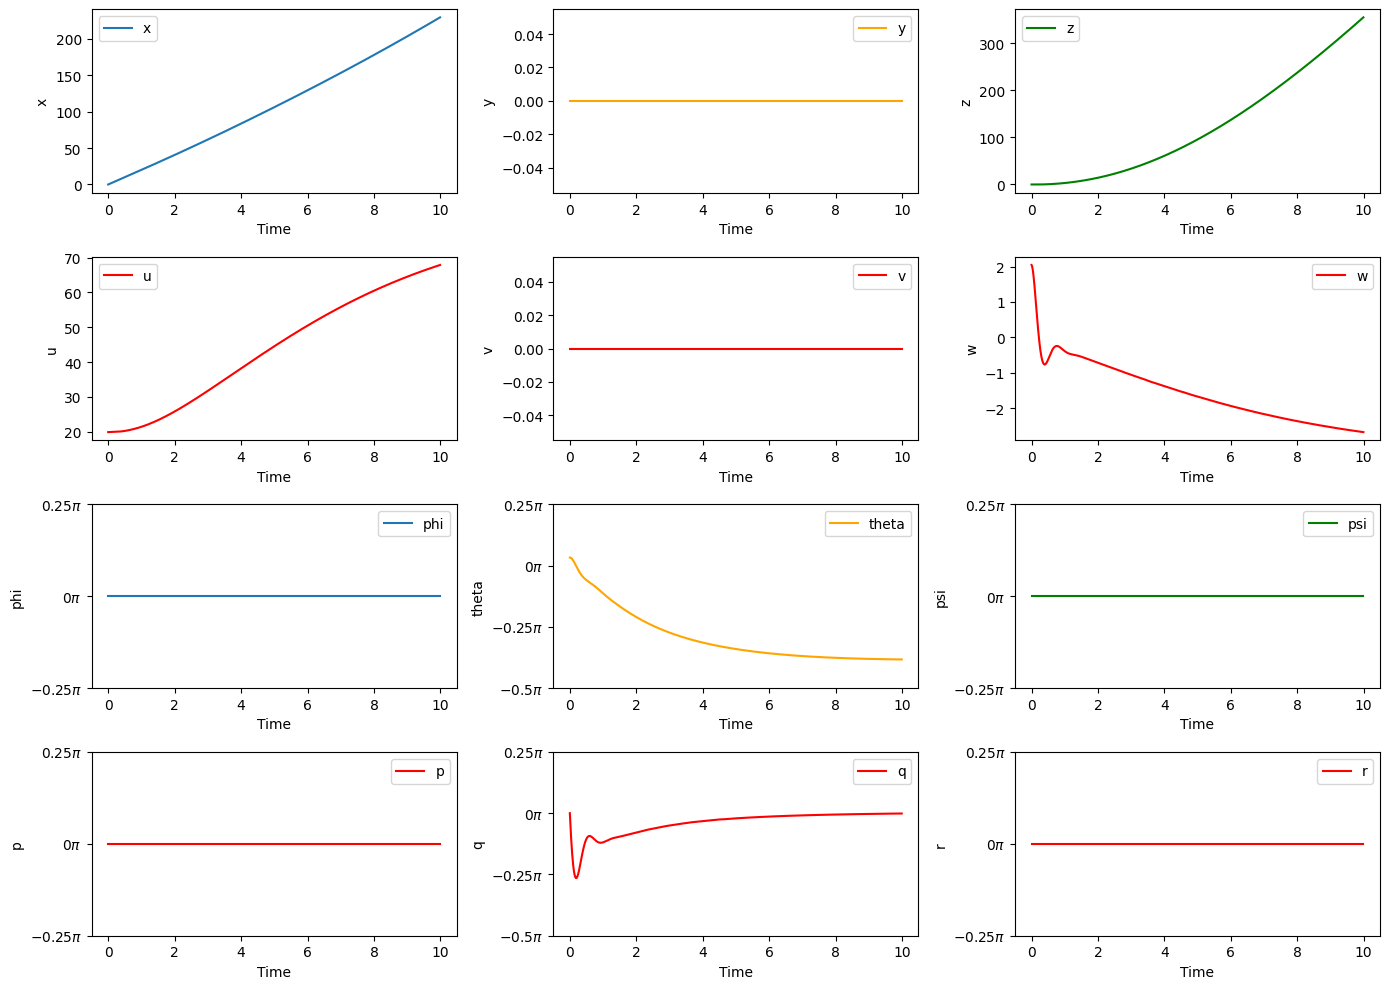

In [21]:
from airplane_plot import plot_airplane_data

plot_airplane_data(sol)

In [22]:
from airplane_3D_EOM_Linear import continuous_linearization, A_matrix_evalation

state_eq = np.array([[x_init], [y_init], [z_init], [phi_init], [theta_init], [psi_init], 
                     [u_init], [v_init], [w_init], [p_init], [q_init], [r_init]])

# input_eq = np.array([[T_init], [elevator_init],[aileron_init],[rudder_init]])
# A_long4, B_long4 = continuous_linearization(state_eq.squeeze(), input_eq.squeeze())
# print(A_long4)
# print(B_long4)

# time_step = 0.01
# A_matrix_evalation(A_long4, time_step)
# print(A_long4.shape[0])


In [23]:
from airplane_3D_EOM_Linear import discrete_simulation

dt = 0.01
duration = 10
state_init = np.array([[u_init], [w_init], [q_init],[theta_init]])
input_init = np.array([[T_init], [elevator_init]])
input_new = np.array([[T_init], [elevator_init+np.pi/8]])

results = discrete_simulation(state_init, input_init, input_new, dt, duration)
print(state_init)
print(input_init)
print(results.shape)

19.8953211449071
1.268
0.55
11.0
0.043
0.02
0.10235736251882788
0.0135
-0.2696557306118093
2.043574452095811
-0.05222901394995524
0.0012956262026287443
-0.0
[[-5.09333877e-02 -1.79784064e-02 -2.04357445e+00 -9.75567072e+00]
 [-6.06779150e-01 -3.63777985e+00  1.94164926e+01 -1.00206673e+00]
 [ 3.26851675e-01 -3.18208080e+00 -4.23779872e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
19.894648922619048
1.268
0.55
11.0
0.043
0.02
0.10203880713258978
0.0135
-0.2696557306118093
2.037101200433085
-0.05221921322787106
0.001291522161074576
0.0
[[-0.05092769  0.07281452 -2.0371012  -9.75567072]
 [-0.69425617 -3.63689245 19.41585224 -1.00206673]
 [ 0.3469778  -3.17980647 -4.23751709  0.        ]
 [ 0.          0.          1.          0.        ]]
19.895821501442438
1.268
0.55
11.0
0.043
0.02
0.10084599384081706
0.0135
-0.2696557306118093
2.013243361881461
-0.05219219882093979
0.0012763962914328461
0.0
[[-0.0509158   0.15960404 -2.01324336 -9.75657633]
 [-

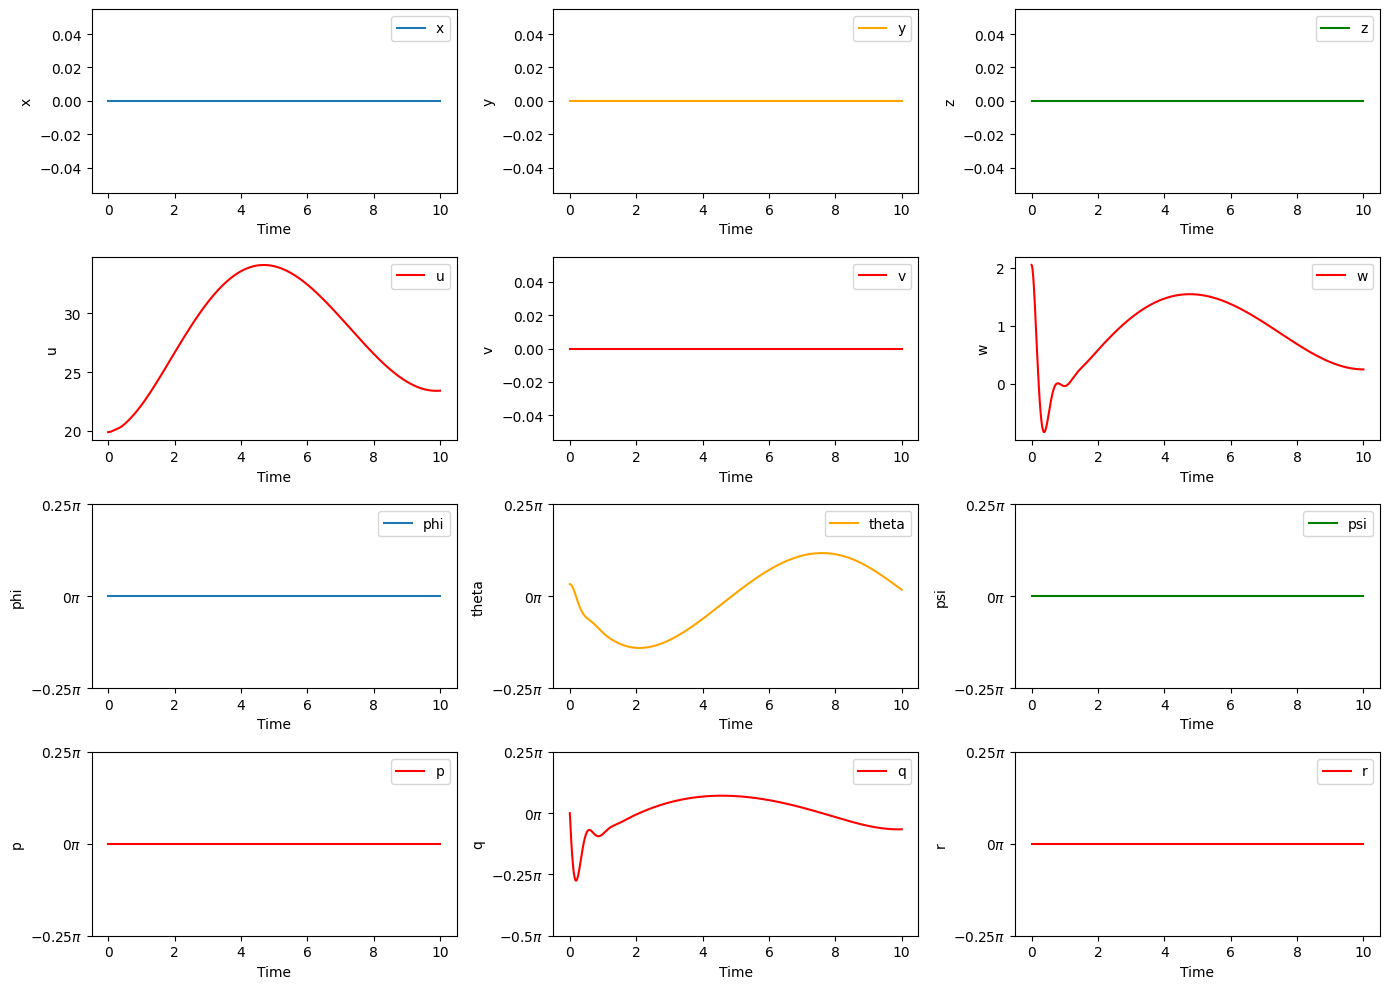

In [24]:
class solutions:
    pass

results_list = results.tolist()


sol_discrete = solutions()
sol_discrete.t = np.arange(0,duration+dt/2,dt).tolist()
sol_discrete.y = [None] * 12
sol_discrete.y[0] = np.zeros_like(sol_discrete.t)
sol_discrete.y[1] = np.zeros_like(sol_discrete.t)
sol_discrete.y[2] = np.zeros_like(sol_discrete.t)
sol_discrete.y[3] = results_list[0]
sol_discrete.y[4] = np.zeros_like(sol_discrete.t)
sol_discrete.y[5] = results_list[1]
sol_discrete.y[6] = np.zeros_like(sol_discrete.t)
sol_discrete.y[7] = results_list[3]
sol_discrete.y[8] = np.zeros_like(sol_discrete.t)
sol_discrete.y[9] = np.zeros_like(sol_discrete.t)
sol_discrete.y[10] = results_list[2]
sol_discrete.y[11] = np.zeros_like(sol_discrete.t)




from airplane_plot import plot_airplane_data

plot_airplane_data(sol_discrete)